## Import Packages

In [37]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

from utils_file.tools import load_cache_file
from utils_file.finance_tools import *

warnings.filterwarnings("ignore")
path = "figure_file"
plt.rcParams["font.family"] = "Times New Roman"

## Load Data

In [15]:
fitting_result = load_cache_file("pre-train-extendWindow/train_39120.pkl")
dqn_fit_result = fitting_result["reward_result"]["episode_3136"]

static_pt_IS = load_cache_file("data_file/static_strategy/ap_reward_result.pkl")

## Boxplot for Reward

In [16]:
static_pt_IS_table = pd.DataFrame(static_pt_IS).T

In [17]:
above_median_x, above_median_y = [], []
below_median_x, below_median_y = [], []

for x, y in enumerate(static_pt_IS_table.median()):
    value = dqn_fit_result[x]

    if value > y:
        above_median_x.append(x + 1)
        above_median_y.append(value)
    
    else:
        below_median_x.append(x + 1)
        below_median_y.append(value)

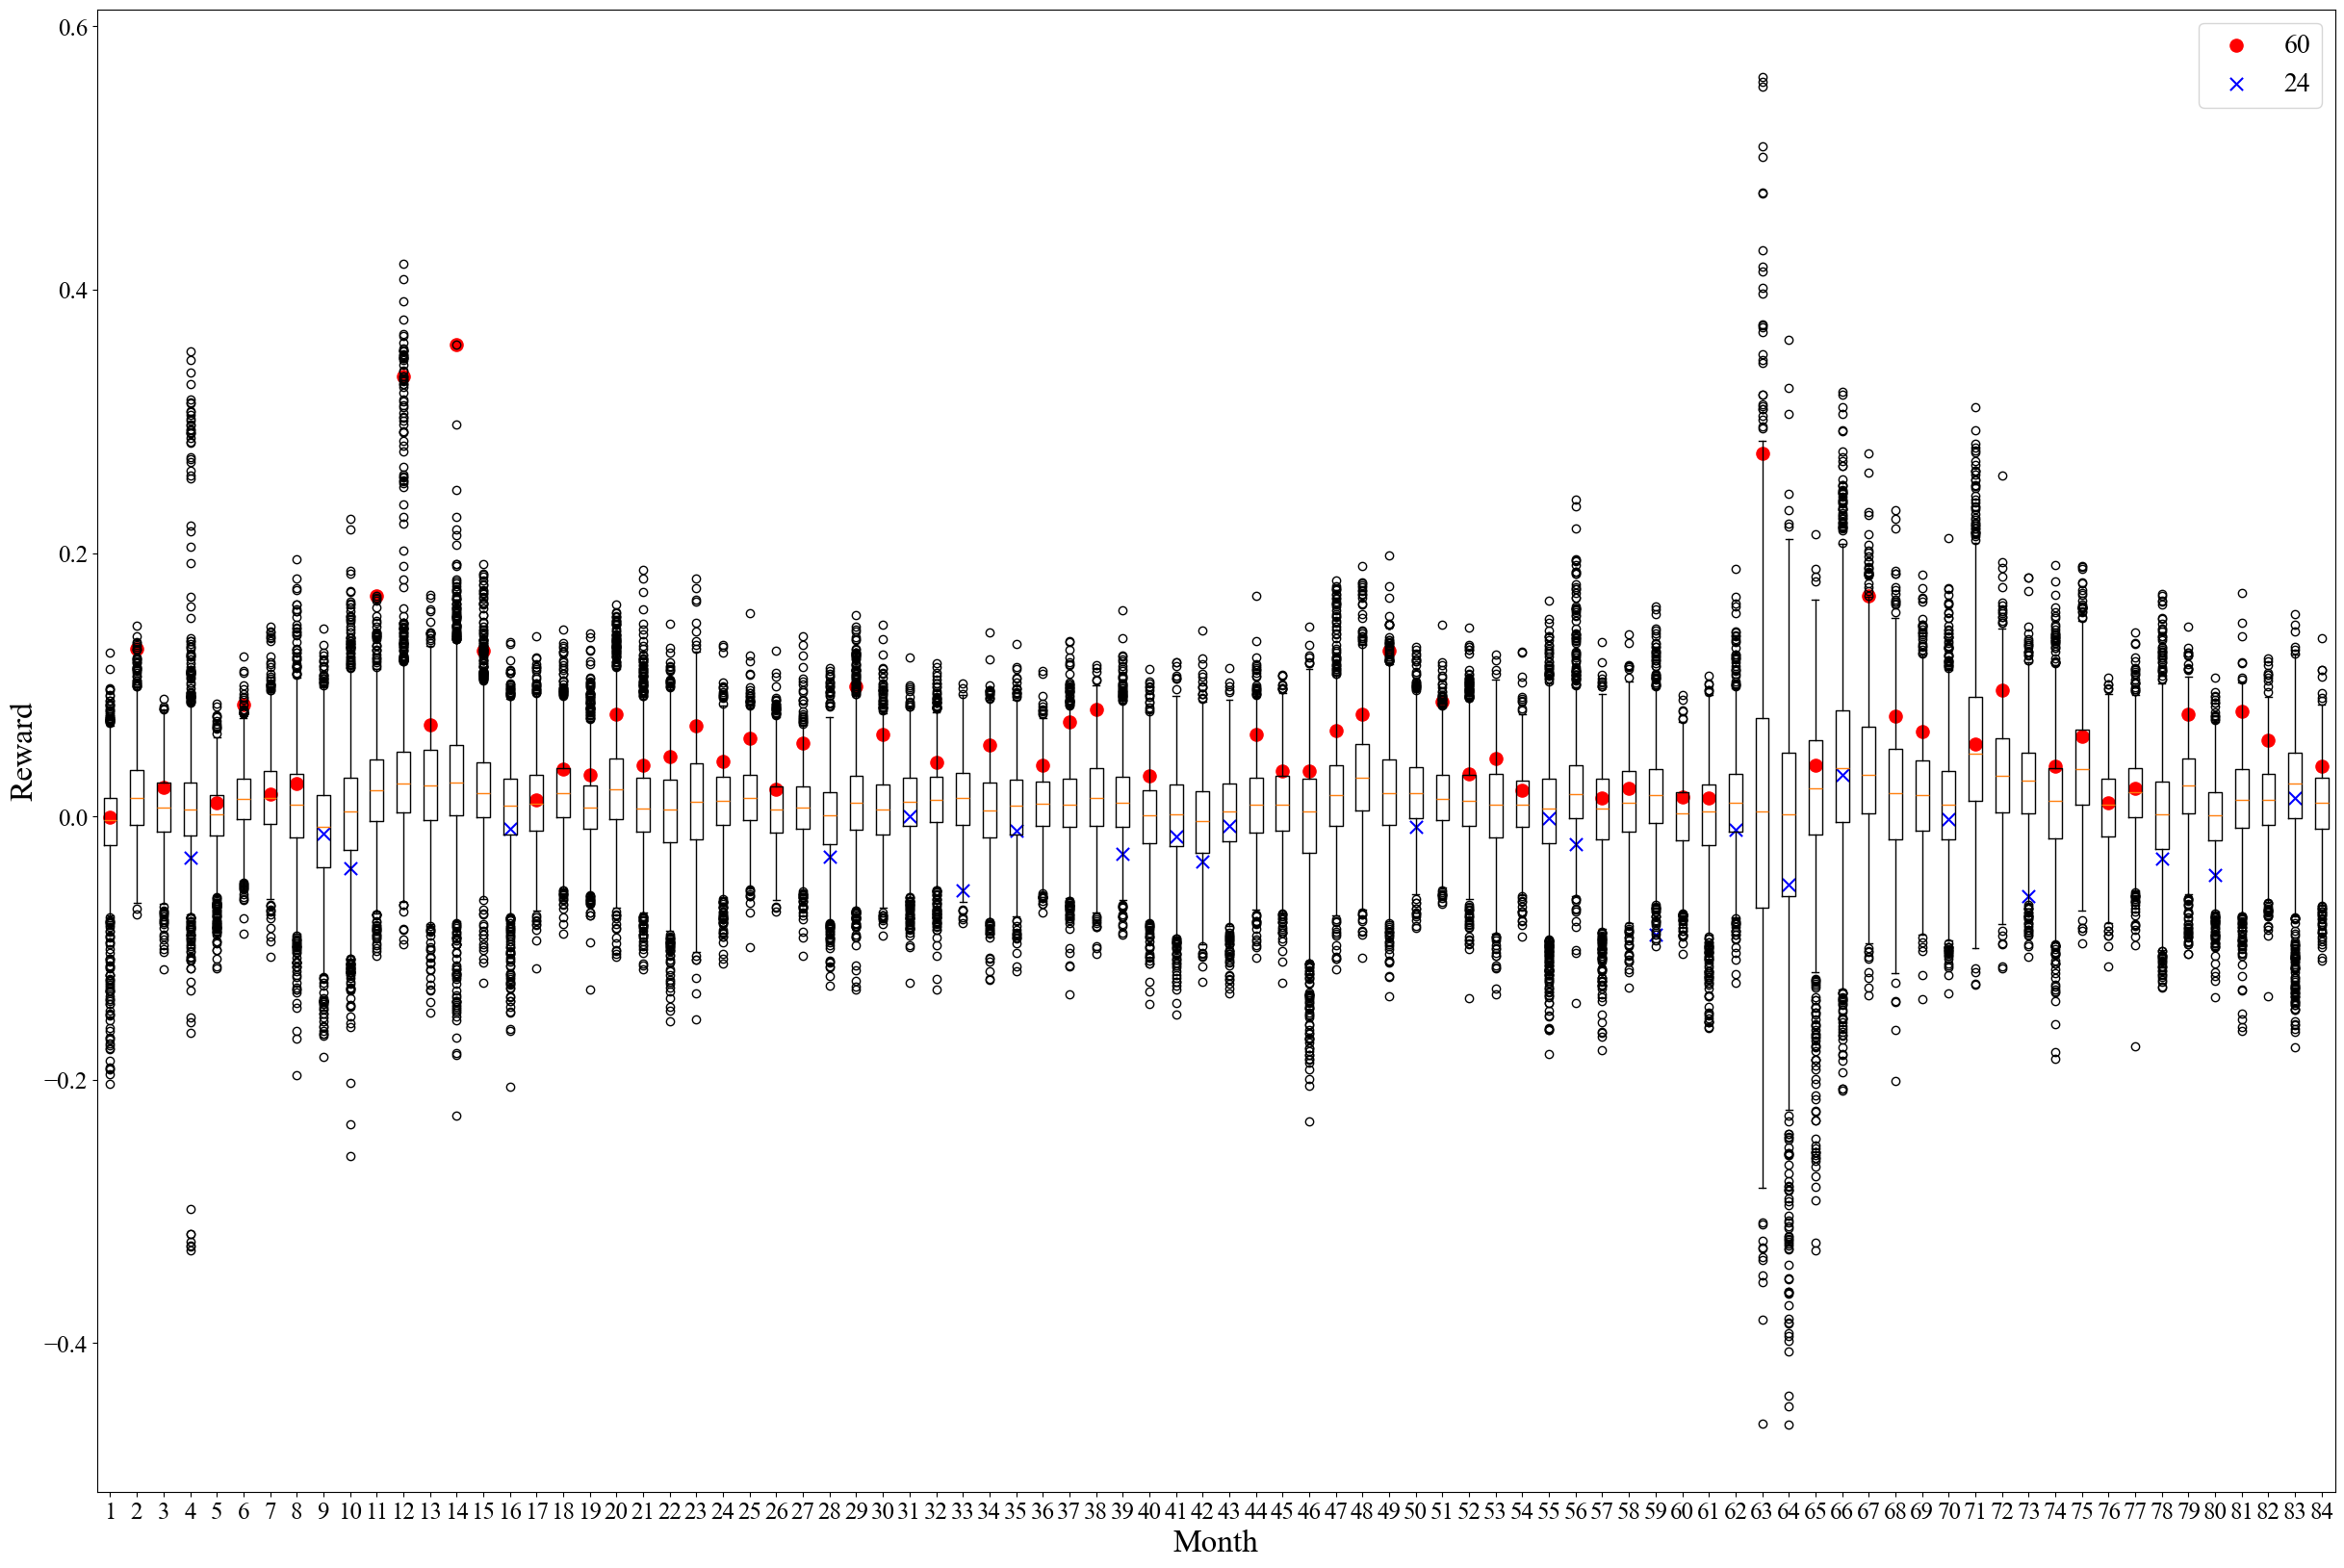

In [52]:
plt.figure(figsize=(30, 20))
plt.boxplot(static_pt_IS_table)
plt.scatter(above_median_x, above_median_y, s=90, color="red", marker="o", label=f"{len(above_median_x)}")
plt.scatter(below_median_x, below_median_y, s=90, color="blue", marker="x", label=f"{len(below_median_x)}")
plt.legend(fontsize=20)
plt.xlabel("Month", fontsize=24)
plt.ylabel("Reward", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("IS_reward_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
statistic, pvalue = wilcoxon(dqn_fit_result, static_pt_IS_table.median(), alternative="greater")
print(f"p-value of WRS test: {pvalue: .4e}")

p-value of WRS test:  2.1604e-05


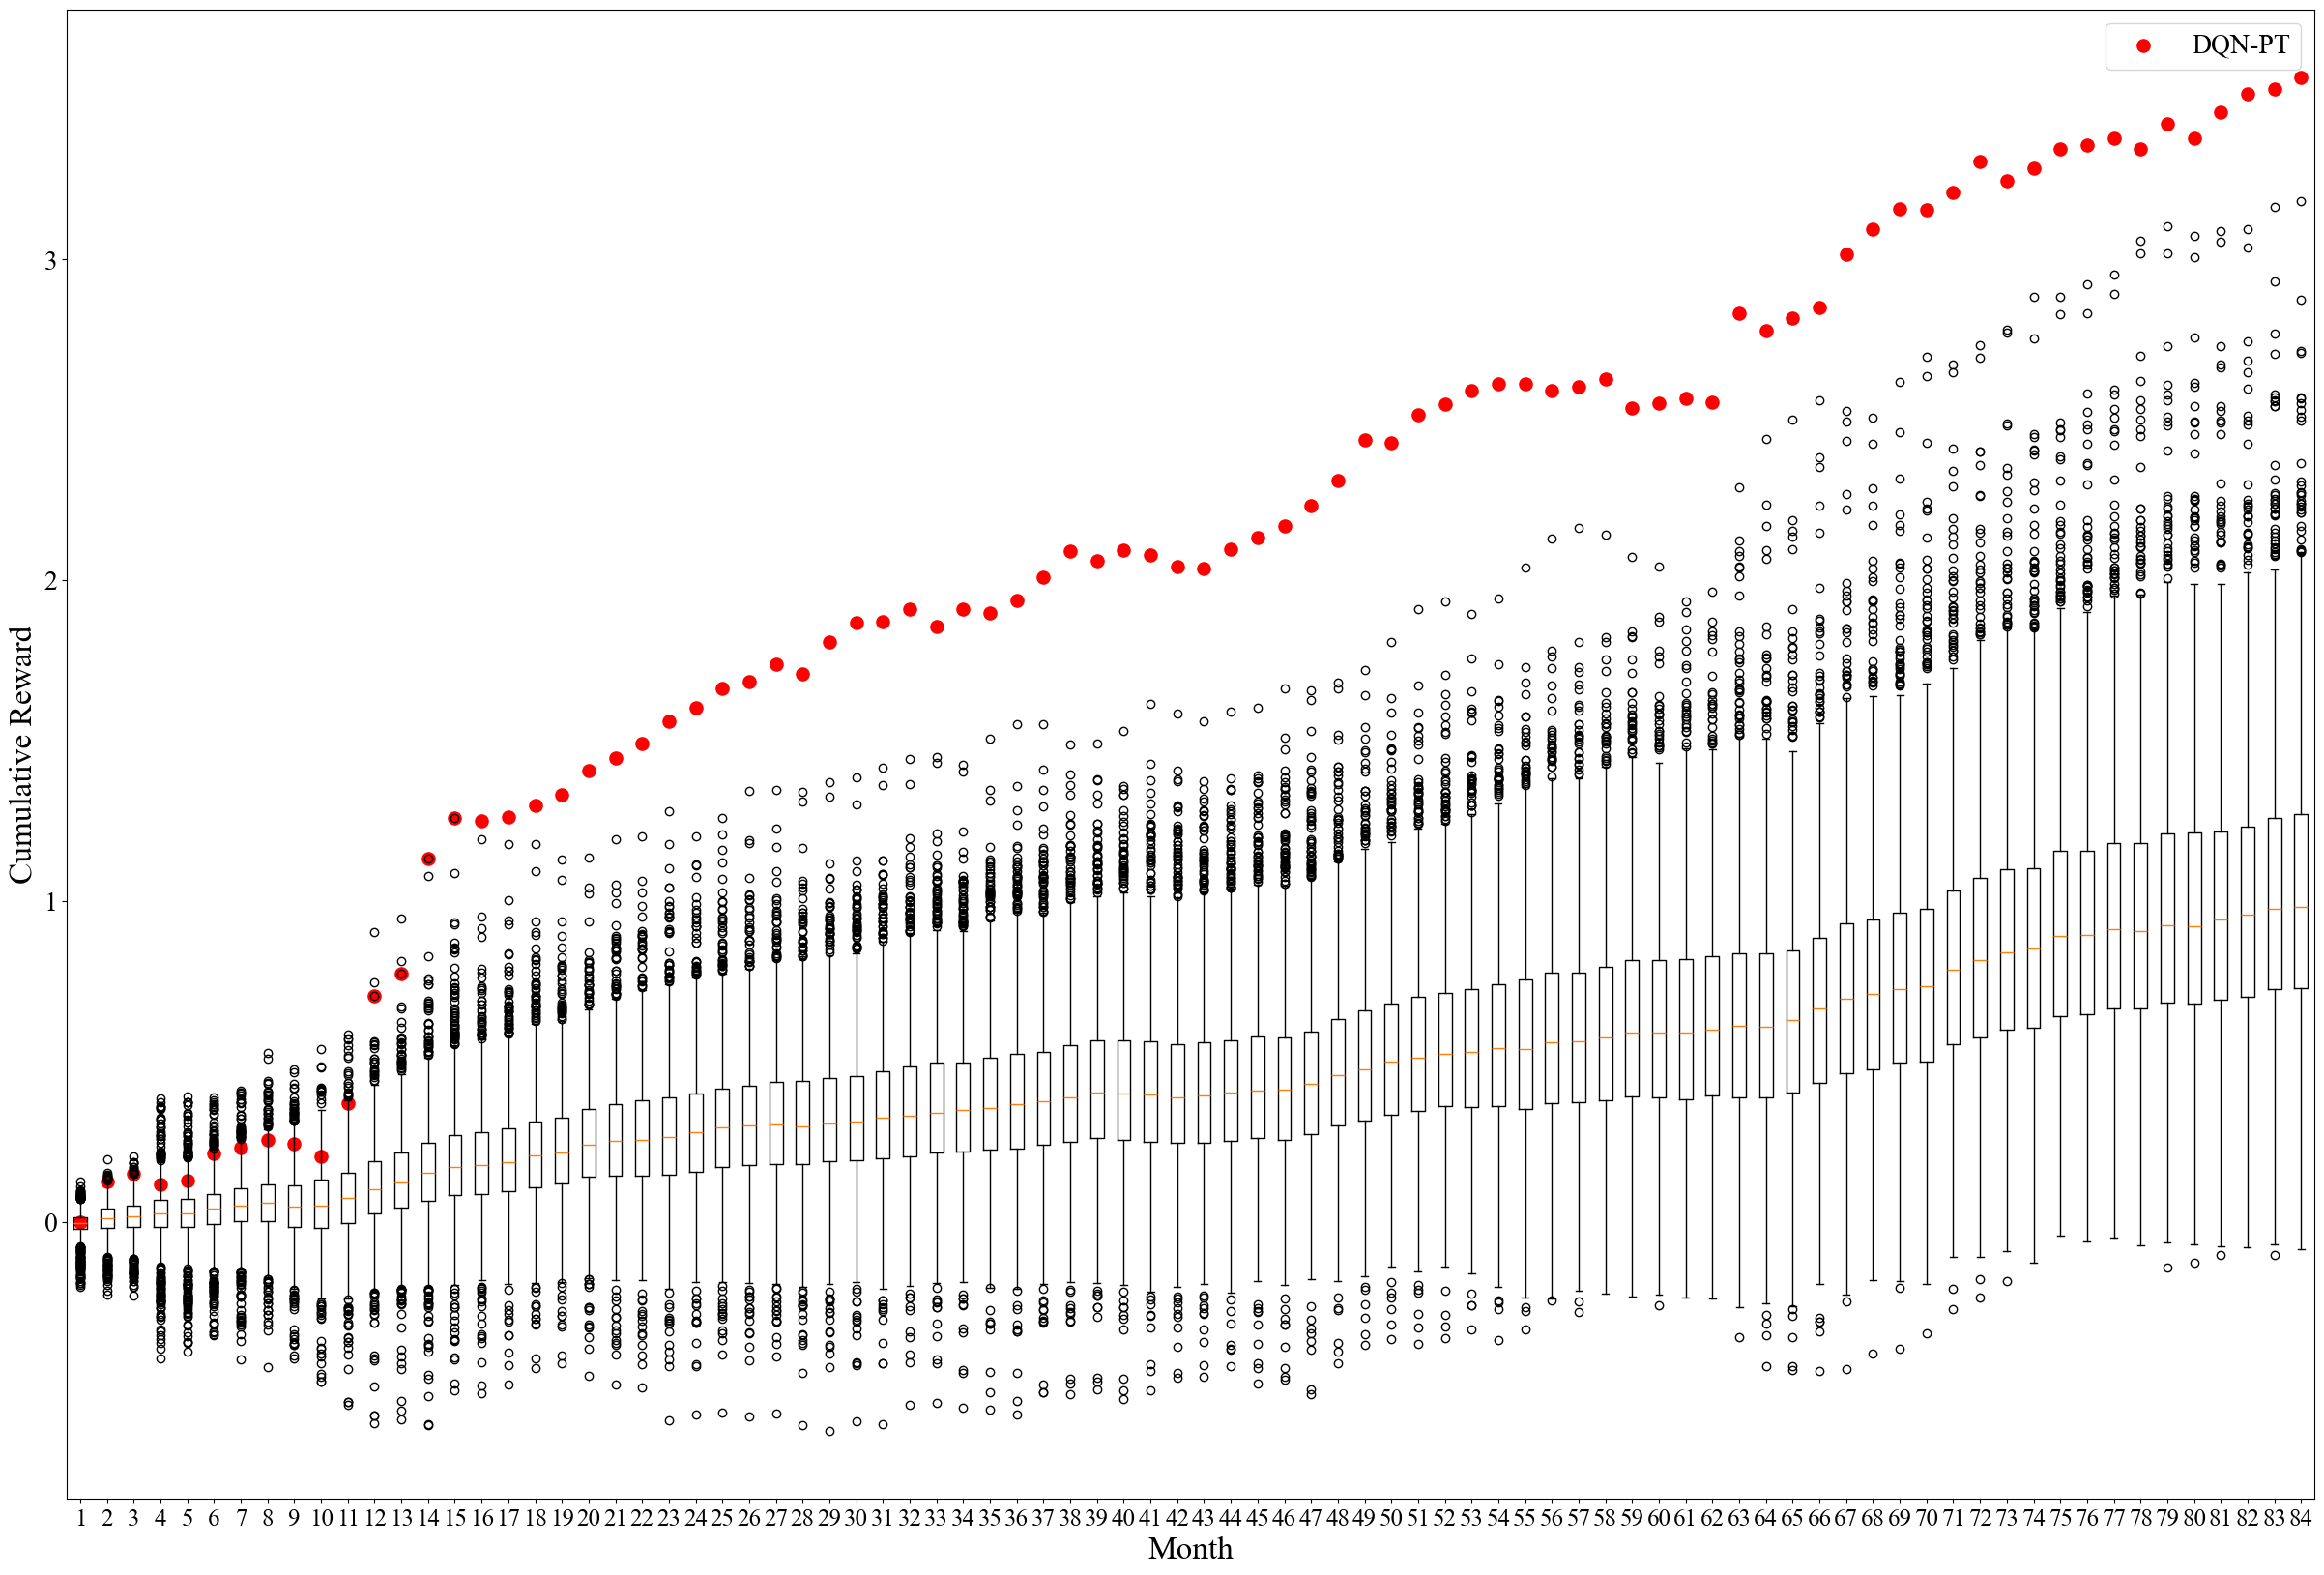

In [51]:
plt.figure(figsize=(30, 20))
plt.boxplot(static_pt_IS_table.cumsum(axis=1))
plt.scatter(range(1, 85), np.array(dqn_fit_result).cumsum(), s=90, color="red", marker="o", label="DQN-PT")
plt.legend(fontsize=20)
plt.xlabel("Month", fontsize=24)
plt.ylabel("Cumulative Reward", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.savefig("IS_cum_reward_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

In [43]:
traesure_2022 = pd.read_csv("data_file/treasury_rates/daily-treasury-rates-2022.csv")
traesure_2023 = pd.read_csv("data_file/treasury_rates/daily-treasury-rates-2023.csv")
traesure_2024 = pd.read_csv("data_file/treasury_rates/daily-treasury-rates-2024.csv")

traesure_total = pd.concat([traesure_2022, traesure_2023, traesure_2024], ignore_index=True)

risk_free_rate = traesure_total["52 WEEKS COUPON EQUIVALENT"].mean() / 100

In [53]:
pd.DataFrame({
    "DQN-PT": [
        Mean_Return(dqn_fit_result), 
        Sharpe_Ratio(dqn_fit_result, risk_free_rate), 
        Sortino_Ratio(dqn_fit_result, risk_free_rate), 
        Profit_Factor(dqn_fit_result), 
        Calmar_Ratio(dqn_fit_result, risk_free_rate),
        Max_Drawdown(dqn_fit_result)
    ],
    "Static-PT": [
        np.mean([Mean_Return(static_pt_IS_table.iloc[x, :]) for x in range(len(static_pt_IS_table))]), 
        np.mean([Sharpe_Ratio(static_pt_IS_table.iloc[x, :], risk_free_rate) for x in range(len(static_pt_IS_table))]), 
        np.mean([Sortino_Ratio(static_pt_IS_table.iloc[x, :], risk_free_rate) for x in range(len(static_pt_IS_table))]), 
        np.mean([Profit_Factor(static_pt_IS_table.iloc[x, :]) for x in range(len(static_pt_IS_table))]), 
        np.mean([Calmar_Ratio(static_pt_IS_table.iloc[x, :], risk_free_rate) for x in range(len(static_pt_IS_table))]),
        np.mean([Max_Drawdown(static_pt_IS_table.iloc[x, :]) for x in range(len(static_pt_IS_table))])
    ]
}, index=[
    "Mean Return",
    "Sharpe Ratio",
    "Sortino Ratio",
    "Profit Factor",
    "Calmar Ratio",
    "Max Drawdown",
]).round(3).to_csv("IS_strategy_comparison.csv", index=True)